In [2]:
from numpy import *
import matplotlib
import matplotlib.pyplot as plt

class Model:

    def __init__(self, T):
        self.T = T
        self.elementList = []
        
    def head(self, x, y):
        return round(sum((e.potential(x,y) for e in self.elementList)) / self.T, 3)

    def solve(self):
        matrix = []
        rhsvec = []
        for e in self.elementList:
            if e.hasunknown:
                row, rhs = e.equation()
                matrix.append( row )
                rhsvec.append( rhs )
        sol = linalg.solve( matrix, rhsvec )
        print(sol)
        ipar = 0
        for e in self.elementList:
            if e.hasunknown:
                e.parameter = sol[ipar]
                ipar = ipar + 1
    
    def make_contour(self, x1, y1, x2, y2, delta, interval):
        xp = arange(x1, x2, delta)
        yp = arange(y1, y2, delta)
        hd = [ [self.head(x, y) for x in xp] for y in yp ]
        
        max_head = []
        for i in range(0,len(hd)):
            max_head.append(max(hd[i]))
        
        contours = array(arange(0,max(max_head),interval))

        xs = 8.0 * (x2 - x1) / (y2 - y1)
        ys = 8.0
        
        matplotlib.rcParams['contour.negative_linestyle'] = 'solid'
        fig = matplotlib.pyplot.gcf()
        fig.set_size_inches(xs, ys)
        plt.axes().set_aspect('equal')
        
        try:
            CS = plt.contour(xp, yp, hd, contours, colors='b')
            plt.clabel(CS, fontsize=11, inline=1)
            
        except ValueError:
            print('Z data are horizontal-planar')
        
class Element:
    def __init__(self, ml, p):
        self.hasunknown = False
        self.model = ml
        self.model.elementList.append(self)
        self.parameter = p

    def potential(self,x,y):
        return self.parameter * self.potinf(x,y)

class Well(Element):
    def __init__(self, ml, xc, yc, Q, rw):
        Element.__init__(self, ml, Q)
        self.xc, self.yc = xc, yc
        self.rwsq = rw**2

    def potinf(self,x,y):
        r2 = (x-self.xc)**2 + (y-self.yc)**2
        rsq = (r2 if r2 > self.rwsq else self.rwsq)
        return 1.0 / (4*pi) * log( rsq )

class UniformFlow(Element):

    def __init__(self, ml, gradient, angle ):
        Element.__init__(self, ml, gradient * ml.T)
        self.ang = angle / 180.0 * pi

    def potinf(self,x,y):
        return -x * cos(self.ang) - y * sin(self.ang)

class HeadEquation:

    def equation(self):
        row = []; rhs = self.pc
        for e in self.model.elementList:
            if e.hasunknown:
                row.append( e.potinf(self.xc,self.yc) )
            else:
                rhs = rhs - e.potential(self.xc,self.yc)
        return row, rhs

class HeadWell(Well,HeadEquation):

    def __init__(self, ml, xc, yc, hw, rw):
        Well.__init__(self, ml, xc, yc, 0.0, rw)
        self.pc = ml.T * hw; self.hasunknown = True

class Constant(Element,HeadEquation):

    def __init__(self, ml, xc, yc, hr):
        Element.__init__(self, ml, 0.0)
        self.xc, self.yc, self.pc = xc, yc, ml.T * hr
        self.hasunknown = True

    def potinf(self,x,y): return ones( shape(x) )

class HeadLineSink(Element,HeadEquation):

    def __init__(self, ml, x1, y1, x2, y2, hls):
        Element.__init__(self, ml, 0.0)
        self.xc, self.yc = 0.5*(x1+x2), 0.5*(y1+y2)
        self.pc = ml.T * hls
        self.hasunknown = True
        self.z1, self.z2 = x1 + y1 * 1j, x2 + y2 * 1j
        self.L = abs(self.z2-self.z1)
        self.x1, self.y1 = x1, y1
        self.x2, self.y2 = x2, y2

    def potinf(self,x,y):
       z = x + y * 1j
       Z = (2*z-(self.z1+self.z2))/(self.z2-self.z1)
       part1 = nan_to_num( (Z + 1) * log(Z + 1) )
       part2 = nan_to_num( (Z - 1) * log(Z - 1) )
       omega = self.L / (4*pi) * ( part1 - part2 )
       return omega.real
    
    def draw(self):
        plt.plot([x1,x2],[y1,y2],'-k')

class Recharge(Element):
    def __init__(self, ml, xc, yc, R, N):
        Element.__init__(self, ml, N)
        self.xc, self.yc = xc, yc
        self.R2 = R*R
    
    def potinf(self, x, y):
        r2 = (x-self.xc)**2 + (y-self.yc)**2
        if r2 <= self.R2:
            return -1/4*(r2-self.R2)
        else:
            return -self.R2/2*log( r2/self.R2)

## Well in Uniform Flow

In [6]:
def pumping_rate(value, units):
    if units == 'cfd':
        pr_in_m3perday = value*0.0283168
        print(pr_in_m3perday)
    else:
        pr_in_cfd = value/0.0283168
        print(pr_in_cfd)

In [7]:
pumping_rate(10000, 'm3')
pumping_rate(50,'cfd')
pumping_rate(0.01,'cfd')

353147.2482766414
1.41584
0.000283168


In [14]:
ml = Model(2500)

Well(ml, 0,0, 10000, .1)

#HeadLineSink(ml,-1000,-1000,-1000,1000,101)
#HeadLineSink(ml, 1000,-1000,1000,1000,99)

for i in range(-1000,1000,100):
    HeadLineSink(ml, -1000,i, -1000,(i+100), 101)   #West Boundary
    HeadLineSink(ml, 1000,i, 1000, (i+100), 99)    #East Boundary   

l = range(-1000,1000, 100)
h = arange(101,99,-(1/20))
lh_zip = list(zip(l,h))

for l,h in lh_zip: 
    HeadLineSink(ml, l,1000, (l+100),1000, h) # North boundary
    HeadLineSink(ml, l,-1000, (l+100),-1000, h) # South boundary

ml.solve()

[ 92.27333064 149.92647354  51.56432706  69.58010481  44.64550977
  58.32719244  39.9338827   51.06197184  36.89167645  46.67263103
  34.75387194  43.72070419  33.22378269  41.67740133  32.15333885
  40.28281838  31.46825621  39.40551208  31.13279912  38.98028486
  31.13279912  38.98028486  31.46825621  39.40551208  32.15333885
  40.28281838  33.22378269  41.67740133  34.75387194  43.72070419
  36.89167645  46.67263103  39.9338827   51.06197184  44.64550977
  58.32719244  51.56432706  69.58010481  92.27333064 149.92647354
  90.32540847  90.32540847  51.67276633  51.67276633  45.0856675
  45.0856675   40.5866106   40.5866106   37.67388069  37.67388069
  35.61553763  35.61553763  34.12470247  34.12470247  33.0560392
  33.0560392   32.33425465  32.33425465  31.91993178  31.91993178
  31.79246153  31.79246153  31.94165368  31.94165368  32.36549451
  32.36549451  33.07293824  33.07293824  34.09106369  34.09106369
  35.47697436  35.47697436  37.33564059  37.33564059  39.85634158
  39.8563415

/Users/AliciaMorrison/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:127: RuntimeWarning: divide by zero encountered in log
/Users/AliciaMorrison/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:127: RuntimeWarning: invalid value encountered in cdouble_scalars
/Users/AliciaMorrison/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:128: RuntimeWarning: divide by zero encountered in log
/Users/AliciaMorrison/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in cdouble_scalars


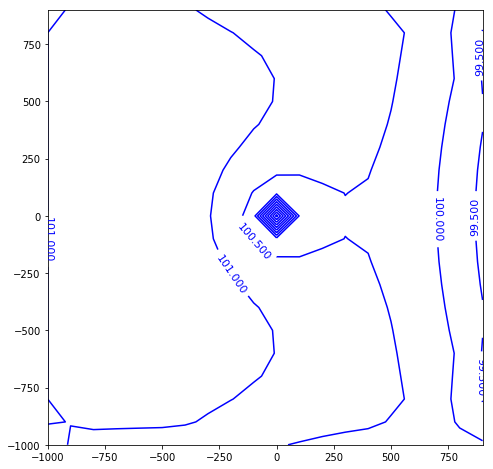

In [20]:
ml.make_contour(-1000,-1000,  1000,1000,  100,  0.5)

In [12]:
ml.head(0,0)

-195.324

## Uniform Flow with Recharge

In [17]:
Recharge(ml, 0,0, 1000, .01)
ml.solve()

[ 76.02373214 133.67687504  44.68620181  62.70197955  40.84892177
  54.53060445  38.80737525  49.9354644   38.08363853  47.86459312
  38.00344046  46.97027271  38.25331182  46.70693047  38.62433797
  46.75381749  38.96307311  46.90032898  39.16120153  47.00868726
  39.16120153  47.00868726  38.96307311  46.90032898  38.62433797
  46.75381749  38.25331182  46.70693047  38.00344046  46.97027271
  38.08363853  47.86459312  38.80737525  49.9354644   40.84892177
  54.53060445  44.68620181  62.70197955  76.02373214 133.67687504
  74.07580997  74.07580997  44.79464107  44.79464107  41.2890795
  41.2890795   39.46010315  39.46010315  38.86584277  38.86584277
  38.86510615  38.86510615  39.1542316   39.1542316   39.52703832
  39.52703832  39.82907155  39.82907155  39.94833419  39.94833419
  39.82086393  39.82086393  39.43647058  39.43647058  38.83649363
  38.83649363  38.10246737  38.10246737  37.34063221  37.34063221
  36.66893644  36.66893644  36.20913314  36.20913314  36.05975358
  36.059753

/Users/AliciaMorrison/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:127: RuntimeWarning: divide by zero encountered in log
/Users/AliciaMorrison/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:127: RuntimeWarning: invalid value encountered in cdouble_scalars
/Users/AliciaMorrison/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:128: RuntimeWarning: divide by zero encountered in log
/Users/AliciaMorrison/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in cdouble_scalars


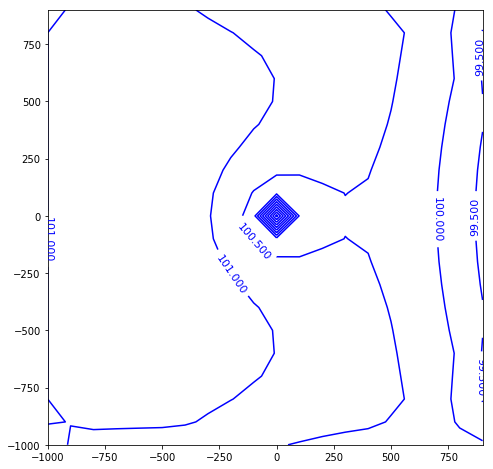

In [18]:
ml.make_contour(-1000,-1000, 1000,1000, 100, 0.5)

In [19]:
ml.head(0,0)

95.784

## Example Problem: Stream Lines 

In [21]:
ml = Model(2500)

HeadWell(ml, 0,0, 22, .1)
HeadWell(ml, 200,200, 23, .1)

for i in range(-1000,1000,100):
    HeadLineSink(ml, -1000,i, -1000,(i+100), 20)   #West Boundary
    HeadLineSink(ml, 1000,i, 1000, (i+100), 25)    #East Boundary

l = range(-1000,1000, 100)
h = arange(20,25,0.25)
lh_zip = list(zip(l,h))

for l,h in lh_zip: 
    HeadLineSink(ml, l,1000, (l+100),1000, h) #North boundary
    HeadLineSink(ml, l,-1000, (l+100),-1000, h) #South boundary

#Stream North

sn_1 = HeadLineSink(ml, -950, -350, -550,-200, 20)
HeadLineSink(ml, -550,-200, -450, 4, 21)
HeadLineSink(ml, -450, 4, -190, 155, 22)
HeadLineSink(ml, -190, 155, 190,540,23)
HeadLineSink(ml, 190,540,280, 700, 24)
HeadLineSink(ml, 280, 700, 375, 995, 25)


#Stream South

HeadLineSink(ml, -950, -415, -490, -545, 20)
HeadLineSink(ml, -490, -545, -290, -645, 21)
HeadLineSink(ml, -290, -645, 50, -420, 22)
HeadLineSink(ml, 50, -420, 345, -350, 23)
HeadLineSink(ml, 345, -350, 575, -165, 24)
HeadLineSink(ml, 575, -165, 1025, -85, 25)


ml.solve()

[ 1.35174111e+03  7.13306555e+02  3.18680200e+01 -4.01962264e+00
  2.00628006e+01 -1.16943299e+00  1.71461984e+01 -8.98733536e-01
  1.44401746e+01 -5.92591280e-01  1.14648683e+01 -1.89887093e-01
  7.28051302e+00  4.18410735e-01  5.94501579e+00  1.38538034e+00
  9.28650437e+00  2.90269334e+00  1.19680689e+01  8.17520751e+00
  1.36399744e+01  9.21946084e+00  1.47978270e+01  2.55033799e+00
  1.56353948e+01  1.63977078e+00  1.62755016e+01  1.19168395e+00
  1.68118538e+01  1.06208882e+00  1.73276587e+01  1.05878401e+00
  1.79104403e+01  1.05312186e+00  1.86763830e+01  9.25290701e-01
  1.98592998e+01  5.49262079e-01  2.15872671e+01 -1.25741680e-01
  3.22852921e+01 -3.69900498e+00  4.17557317e+01  4.13397397e+01
  2.06478170e+01  1.92192105e+01  1.71916536e+01  1.49523225e+01
  1.49144024e+01  1.20325401e+01  1.35168763e+01  1.01753042e+01
  1.26213806e+01  8.97708979e+00  1.21052813e+01  8.24970394e+00
  1.19486396e+01  7.84384460e+00  1.22265687e+01  7.61503887e+00
  1.31589770e+01  7.45078

In [22]:
print('Model Center:', ml.head(0,0))
print('Western Edge:', ml.head(-999.99,0))
print('Eastern Edge:', ml.head(999.99, 0))

Model Center: 22.0
Western Edge: 20.0
Eastern Edge: 24.989


/Users/AliciaMorrison/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:127: RuntimeWarning: divide by zero encountered in log
/Users/AliciaMorrison/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:127: RuntimeWarning: invalid value encountered in cdouble_scalars
/Users/AliciaMorrison/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:128: RuntimeWarning: divide by zero encountered in log
/Users/AliciaMorrison/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in cdouble_scalars


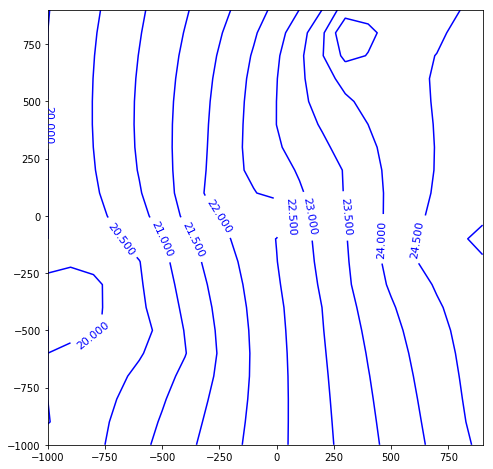

In [23]:
ml.make_contour(-1000,-1000, 1000,1000, 100,.5)

In [114]:
ml.head(0,0)

22.0

## Stream Lines with Recharage

In [24]:
Recharge(ml, 0,0, 1414, 0.01)
ml.solve()

[ 1.74594478e+03  1.16741793e+03  1.97061865e+01 -1.60780237e+01
  1.51921855e+01 -5.65747742e+00  1.38571371e+01 -3.50729123e+00
  1.19755872e+01 -1.99012313e+00  9.10505679e+00 -8.94512924e-01
  4.21905374e+00  3.73555831e-02  2.87622148e+00  9.91548547e-01
  7.66141841e+00  2.13984202e+00  1.14319654e+01  5.19645168e+00
  1.37581066e+01  5.99688070e+00  1.53351939e+01  2.70023187e+00
  1.64193717e+01  2.31579218e+00  1.71458186e+01  2.05377229e+00
  1.75945324e+01  1.81334376e+00  1.78192352e+01  1.45526627e+00
  1.78605129e+01  8.46880087e-01  1.77566780e+01 -1.83598524e-01
  1.75764675e+01 -1.91426481e+00  1.72893213e+01 -4.55396526e+00
  2.02814485e+01 -1.57440911e+01  2.97518845e+01  2.91781583e+01
  1.63507116e+01  1.43777678e+01  1.49130185e+01  1.18088240e+01
  1.40063671e+01  9.98991804e+00  1.34915295e+01  8.80995845e+00
  1.31565139e+01  8.05154715e+00  1.29558580e+01  7.64231274e+00
  1.29139577e+01  7.51904654e+00  1.31313269e+01  7.56974034e+00
  1.38394977e+01  7.65939

/Users/AliciaMorrison/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:127: RuntimeWarning: divide by zero encountered in log
/Users/AliciaMorrison/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:127: RuntimeWarning: invalid value encountered in cdouble_scalars
/Users/AliciaMorrison/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:128: RuntimeWarning: divide by zero encountered in log
/Users/AliciaMorrison/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in cdouble_scalars


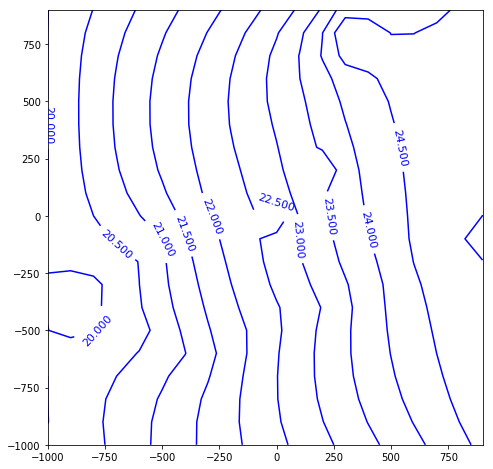

In [26]:
ml.make_contour(-1000,-1000, 1000,1000,100,.5)

In [117]:
ml.head(0,0)

22.0

In [200]:
def set_N(N):
    
    ml = Model(50)
    # Head specified wells
    HeadWell(ml, 0,0, 22, .1)
    HeadWell(ml, 200,200, 23, .1)

    for i in range(-1000,1000,100):
        HeadLineSink(ml, -1000,i, -1000,(i+100), 25)   #West Boundary
        HeadLineSink(ml, 1000,i, 1000, (i+100), 20)    #East Boundary    

    l = range(-1000,1000, 100)
    h = arange(25,20,-(1/20))
    lh_zip = list(zip(l,h))

    for l,h in lh_zip: 
        HeadLineSink(ml, l,1000, (l+100),1000, h) # North boundary
        HeadLineSink(ml, l,-1000, (l+100),-1000, h) # South boundary


    #Stream North
    HeadLineSink(ml, -950, -350, -550,-200, 20)
    HeadLineSink(ml, -550,-200, -450, 4, 21)
    HeadLineSink(ml, -450, 4, -190, 155, 22)
    HeadLineSink(ml, -190, 155, 190,540,23)
    HeadLineSink(ml, 190,540,280, 700, 24)
    HeadLineSink(ml, 280, 700, 375, 995, 25)

    #Stream South
    HeadLineSink(ml, -950, -415, -490, -545, 20)
    HeadLineSink(ml, -490, -545, -290, -645, 21)
    HeadLineSink(ml, -290, -645, 50, -420, 22)
    HeadLineSink(ml, 50, -420, 345, -350, 23)
    HeadLineSink(ml, 345, -350, 575, -165, 24)
    HeadLineSink(ml, 575, -165, 1025, -85, 25)

    #Recharge with variable recharge rate
    Recharge(ml, 0,0, 1000, N)

    model_list.append(ml)

    ml.solve()
    ml.make_contour(-1000,-1000, 1000,1000, 25)

[ 6.31412756e+01  4.92926456e+01 -1.00807499e+00  3.24485655e+00
 -6.63658118e-01  7.84381859e-01 -6.93194011e-01  6.59091592e-01
 -8.14004665e-01  6.55469719e-01 -1.09165978e+00  7.38935859e-01
 -1.65617164e+00  8.74599915e-01 -1.74386948e+00  1.06495353e+00
 -1.01887721e+00  1.32473662e+00 -4.60107997e-01  2.06404172e+00
 -1.28412742e-01  2.22659262e+00  6.99049645e-02  1.34544146e+00
  1.72618770e-01  1.17898911e+00  2.03523226e-01  1.03739648e+00
  1.80042209e-01  9.13133189e-01  1.15932591e-01  7.98723594e-01
  2.14837049e-02  7.01035757e-01 -9.73016906e-02  6.36466496e-01
 -2.41932372e-01  6.49482780e-01 -4.13191065e-01  7.79751990e-01
 -9.39886961e-01  3.24354598e+00 -9.82066495e-01 -1.05006286e+00
 -4.14784716e-01 -6.46429684e-01 -2.33772558e-01 -5.91667963e-01
 -7.63627368e-02 -5.26074518e-01  6.10932815e-02 -4.41008489e-01
  1.83188939e-01 -3.31574214e-01  2.87104183e-01 -2.01584924e-01
  3.66758236e-01 -6.05965271e-02  4.14952292e-01  7.39222265e-02
  4.25788616e-01  1.80752

/Users/AliciaMorrison/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:118: RuntimeWarning: divide by zero encountered in log
/Users/AliciaMorrison/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:118: RuntimeWarning: invalid value encountered in cdouble_scalars
/Users/AliciaMorrison/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:119: RuntimeWarning: divide by zero encountered in log
/Users/AliciaMorrison/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:119: RuntimeWarning: invalid value encountered in cdouble_scalars


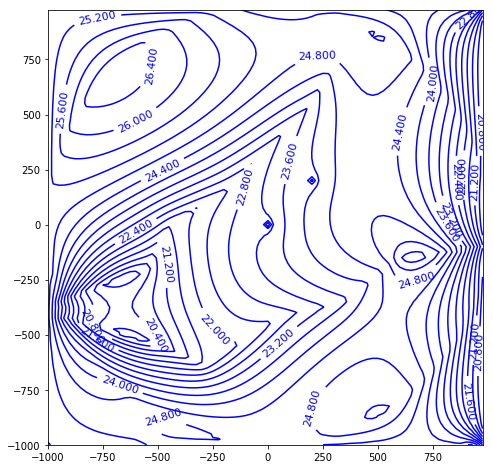

In [201]:
set_N(0.001)

[ 4.22798699e+02  4.82521649e+02 -1.30049134e+01 -8.60244672e+00
 -6.71949765e+00 -4.71716198e+00 -5.35402793e+00 -3.00616853e+00
 -4.54098635e+00 -1.49391409e+00 -4.47763130e+00 -1.84986722e-01
 -5.55217275e+00  9.25728378e-01 -4.68080364e+00  1.76964330e+00
 -1.35780575e+00  2.23384618e+00  1.05295792e+00  9.59348316e-01
  2.46081196e+00  1.09633155e+00  3.16758719e+00  3.98119878e+00
  3.29763046e+00  4.12826084e+00  2.94386914e+00  3.70322584e+00
  2.19381108e+00  2.82455083e+00  1.12943036e+00  1.64040101e+00
 -1.86100746e-01  2.56577874e-01 -1.72713811e+00 -1.26142092e+00
 -3.55463506e+00 -2.91212811e+00 -5.70956586e+00 -4.69395733e+00
 -1.27283099e+01 -8.60052872e+00 -1.27704875e+01 -1.30464657e+01
 -5.71031828e+00 -6.65563930e+00 -3.54230696e+00 -5.02063258e+00
 -1.69463172e+00 -3.58681199e+00 -1.22157777e-01 -2.28521151e+00
  1.23972165e+00 -1.03218688e+00  2.36770101e+00  1.79627735e-01
  3.19981228e+00  1.31675771e+00  3.65536498e+00  2.28769112e+00
  3.65272161e+00  2.96439

/Users/AliciaMorrison/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:136: RuntimeWarning: divide by zero encountered in log
/Users/AliciaMorrison/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:136: RuntimeWarning: invalid value encountered in cdouble_scalars
/Users/AliciaMorrison/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:137: RuntimeWarning: divide by zero encountered in log
/Users/AliciaMorrison/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:137: RuntimeWarning: invalid value encountered in cdouble_scalars


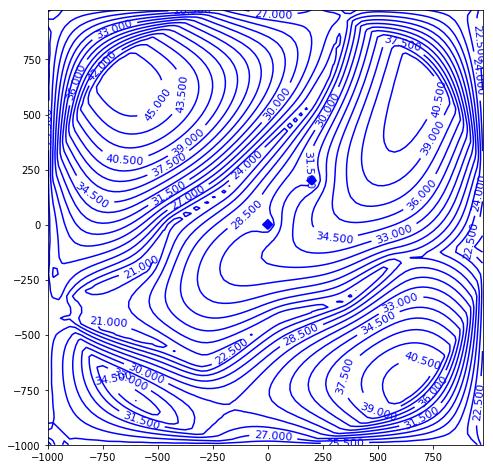

In [126]:
set_N(0.01)

[ 4.01937294e+03  4.81481168e+03 -1.32973297e+02 -1.27075479e+02
 -6.72778930e+01 -5.97326004e+01 -5.19623672e+01 -3.96587698e+01
 -4.18108032e+01 -2.29877522e+01 -3.83373464e+01 -9.42421253e+00
 -4.45121839e+01  1.43701301e+00 -3.40501452e+01  8.81654103e+00
 -4.74709118e+00  1.13249418e+01  1.61836171e+01 -1.00875858e+01
  2.83530590e+01 -1.02062791e+01  3.41444095e+01  3.03387720e+01
  3.45477473e+01  3.36209781e+01  3.03473283e+01  3.03615194e+01
  2.23314998e+01  2.19387272e+01  1.12644081e+01  1.00571752e+01
 -2.26194525e+00 -4.18800095e+00 -1.80255023e+01 -2.02402951e+01
 -3.66816619e+01 -3.85282370e+01 -5.86733138e+01 -5.94310506e+01
 -1.30612539e+02 -1.27041276e+02 -1.30654698e+02 -1.33010494e+02
 -5.86656540e+01 -6.67477354e+01 -3.66276510e+01 -4.93102788e+01
 -1.78773215e+01 -3.41941867e+01 -1.95466837e+00 -2.07272417e+01
  1.18050488e+01 -8.03831359e+00  2.31736693e+01  3.99175432e+00
  3.15303527e+01  1.50903001e+01  3.60594919e+01  2.44253800e+01
  3.59220515e+01  3.08008

/Users/AliciaMorrison/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:136: RuntimeWarning: divide by zero encountered in log
/Users/AliciaMorrison/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:136: RuntimeWarning: invalid value encountered in cdouble_scalars
/Users/AliciaMorrison/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:137: RuntimeWarning: divide by zero encountered in log
/Users/AliciaMorrison/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:137: RuntimeWarning: invalid value encountered in cdouble_scalars


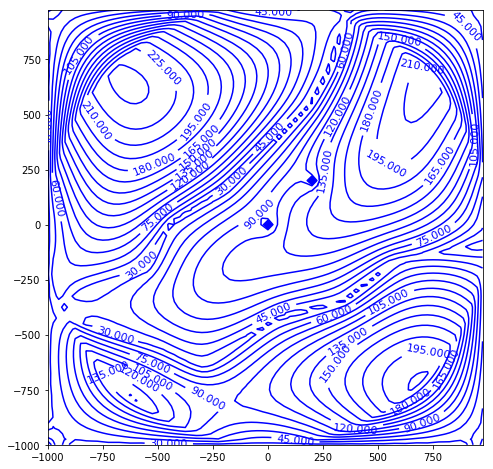

In [128]:
set_N(0.1)

In [171]:
model_names = []
for ml in range(0,5,1):
    model_names.append('ml_'+str(ml))

In [1]:
model_list =[]
for ml in range(0,5,1):
    ml = Model(50)
    HeadLineSink(ml,0,0,1000,1000,25)
    model_list.append(i)

NameError: name 'Model' is not defined

In [188]:
model_list[0].elementList

In [271]:
max_head = []
for i in range(0,len(hd)):
    max_head.append(max(hd[i]))

/Users/AliciaMorrison/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:121: RuntimeWarning: divide by zero encountered in log
/Users/AliciaMorrison/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:121: RuntimeWarning: invalid value encountered in cdouble_scalars
/Users/AliciaMorrison/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:122: RuntimeWarning: divide by zero encountered in log
/Users/AliciaMorrison/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:122: RuntimeWarning: invalid value encountered in cdouble_scalars


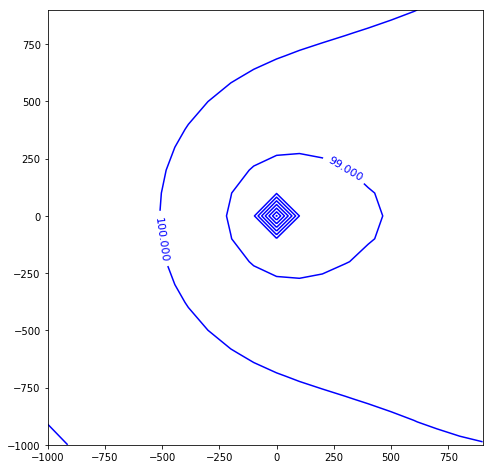

In [276]:
plotter(1)